In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [2]:
datapath = '/mnt/ssd/workspace/stability/MLstability/training_data/'
features = 'orbsummaryfeaturesxgbNorbits10000.0Nout1729window10/'
resonant = pd.read_csv(datapath+'resonant/'+features+'trainingdata.csv', index_col = 0)
random = pd.read_csv(datapath+'random/'+features+'trainingdata.csv', index_col = 0)

In [3]:
dataset = random.append(resonant)#.concat([random, resonant], ignore_index=True, axis=1)
dataset = dataset.reset_index(drop=True)
dataset.tail()

,t_final_short,avg_beta12,std_beta12,min_beta12,max_beta12,avg_beta23,std_beta23,min_beta23,max_beta23,avg_a1,...,min_eH3,avg_iH3,std_iH3,max_iH3,min_iH3,avg_ecross3,std_ecross3,max_ecross3,min_ecross3,norm_a3_slope
34994,10000.0,7.998802,0.008996,7.958388,8.016151,17.944298,0.004377,17.927089,17.951622,1.000167,...,0.664523,0.344042,0.192604,0.684308,0.087439,0.019168,0.010731,0.206576,0.037023,1.101250e-15
34995,10000.0,5.892379,0.019728,5.766043,5.929747,26.676464,0.011881,26.653673,26.753495,1.000011,...,0.022152,0.495810,0.001135,0.497038,0.492698,0.018586,0.000043,0.001847,0.000830,1.862272e-15
34996,10000.0,5.683159,1.209629,4.391778,8.995134,18.258655,3.928340,7.946230,22.539890,0.999809,...,1.278252,0.466321,0.112237,0.624529,0.075747,0.021811,0.005250,0.832730,0.059788,-1.054180e-10
34997,10000.0,29.006055,0.023077,28.956711,29.087669,7.972244,0.026352,7.881264,8.027482,0.999998,...,2.073606,2.323131,0.085659,2.436218,2.141742,0.289636,0.010679,0.313041,0.258526,8.178253e-16
34998,10000.0,7.059031,0.028044,6.973700,7.116762,24.935193,0.060206,24.805194,25.118998,1.000007,...,0.300354,2.770958,1.485998,5.287699,0.278093,0.111174,0.059620,0.257749,0.012051,-1.808660e-12


In [4]:
reslabels = pd.read_csv(datapath+'resonant/'+features+'labels.csv', index_col=0)
randlabels = pd.read_csv(datapath+'random/'+features+'labels.csv', index_col=0)
labels = randlabels.append(reslabels)
labels = labels.reset_index(drop=True)
labels.tail()

,runstring,instability_time,shadow_instability_time,Stable
34994,0009995.bin,9.990000e+08,9.990000e+08,True
34995,0009996.bin,3.814426e+06,6.124299e+06,False
34996,0009997.bin,1.498363e+04,3.320307e+03,False
34997,0009998.bin,9.419807e+05,8.353625e+05,False
34998,0009999.bin,1.895071e+07,2.047024e+07,False


In [5]:
features = []
features += ['avg_iH1', 'avg_iH2']
features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
features += ['avg_beta12','std_beta12','min_beta12','max_beta12','avg_beta23','std_beta23','min_beta23','max_beta23'] 
y = labels['Stable']
X = dataset[features]
X.head()

,avg_iH1,avg_iH2,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,norm_std_a2,norm_max_a2,norm_std_window10_a2,norm_max_window10_a2,...,norm_a2_slope,norm_a3_slope,avg_beta12,std_beta12,min_beta12,max_beta12,avg_beta23,std_beta23,min_beta23,max_beta23
0,0.396213,0.478865,0.000388,0.001293,0.000336,0.000583,0.000832,0.002551,0.000745,0.001293,...,-1.657231e-12,4.849073e-12,8.483517,0.057098,8.303471,8.556362,15.793710,0.092834,15.575529,16.123424
1,1.046322,0.837912,0.000710,0.002449,0.000075,0.000136,0.000197,0.000389,0.000127,0.000252,...,5.754337e-13,-3.581334e-13,8.422873,0.038531,8.290490,8.538080,15.313540,0.036489,15.247157,15.373060
2,2.406573,3.180981,0.279397,1.457620,0.001837,0.002460,0.088457,0.216404,0.002200,0.002950,...,-1.599032e-08,-1.451188e-09,-2.642935,5.740286,-19.721570,5.291956,30.871959,5.520858,21.075916,49.209307
3,0.435315,0.557820,0.000025,0.000120,0.000030,0.000086,0.000017,0.000048,0.000016,0.000028,...,-3.538088e-14,1.594421e-13,18.513730,0.003400,18.498146,18.522660,19.142632,0.008431,19.121812,19.158502
4,5.441820,3.714162,0.005532,0.022189,0.000108,0.000250,0.016743,0.043827,0.001022,0.001952,...,-9.065128e-10,-7.748364e-11,4.212652,3.453793,-3.047322,11.449205,3.808669,2.215113,-1.086974,10.230262


In [6]:
X.shape

(34999, 37)

In [7]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)
xgbc = XGBClassifier(seed = 0)

In [8]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [9]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [10]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.9602371599999999                                  
ERROR                                               
0.002502488412249193                                
HOLDOUT SCORE                                       
0.9673935373710812                                  
SCORE:                                                                        
0.9614505999999998                                                            
ERROR                                                                         
0.0026951762103776403                                                         
HOLDOUT SCORE                                                                 
0.9692049384058782                                                            
SCORE:                                                                        
0.9525844400000001                                                            
ERROR                                             

0.002872238631151633                                                           
HOLDOUT SCORE                                                                  
0.9682224429438218                                                             
SCORE:                                                                         
0.9602442                                                                      
ERROR                                                                          
0.0029071530843445504                                                          
HOLDOUT SCORE                                                                  
0.9681175912982375                                                             
SCORE:                                                                         
0.9590854999999999                                                             
ERROR                                                                          
0.0031339156332502414                   

0.0030983076148918876                                                          
HOLDOUT SCORE                                                                  
0.9676981847159001                                                             
SCORE:                                                                         
0.95943076                                                                     
ERROR                                                                          
0.0029744643646218787                                                          
HOLDOUT SCORE                                                                  
0.9645631205129273                                                             
SCORE:                                                                         
0.95806574                                                                     
ERROR                                                                          
0.0035419127802557918                   

In [11]:
#fit the smaller rage 
#{'x_learning_rate': 0.07419653015127085,
# 'x_max_depth': 8,
# 'x_min_child': 4.0,
# 'x_pos_weight': 8.889472764333366,
# 'x_subsample': 0.9380315392096068,
# 'x_tree_colsample': 0.734517699234413}

#{'x_learning_rate': 0.19890696372714528,
# 'x_max_depth': 17,
# 'x_min_child': 8.0,
# 'x_pos_weight': 12.505309968632893,
# 'x_subsample': 0.9409498631912948,
# 'x_tree_colsample': 0.7528946858805113}

best

{'x_learning_rate': 0.1580032354715947,
 'x_max_depth': 15,
 'x_min_child': 6.0,
 'x_pos_weight': 13.947799535391095,
 'x_subsample': 0.8801541406660105,
 'x_tree_colsample': 0.6990048686946496}

In [12]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-auc:0.966779+0.00112736	test-auc:0.946077+0.00347168
[1]	train-auc:0.978175+0.000918863	test-auc:0.954368+0.00378855
[2]	train-auc:0.982001+0.00116534	test-auc:0.957743+0.00330612
[3]	train-auc:0.984929+0.00126682	test-auc:0.960317+0.0033132
[4]	train-auc:0.986796+0.00124266	test-auc:0.962037+0.00300875
[5]	train-auc:0.988399+0.000673679	test-auc:0.963734+0.00281052
[6]	train-auc:0.989631+0.000750111	test-auc:0.965077+0.00239518
[7]	train-auc:0.990655+0.000658285	test-auc:0.965897+0.00234261
[8]	train-auc:0.991611+0.000692766	test-auc:0.966561+0.00221021
[9]	train-auc:0.992594+0.000498199	test-auc:0.96701+0.00215127
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.966779       0.001127       0.946077      0.003472
1        0.978175       0.000919       0.954368      0.003789
2        0.982001       0.001165       0.957743      0.003306
3        0.984929       0.001267       0.960317      0.003313
4        0.986796       0.001243       0.962037      0.0

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.947100090327679


In [13]:
#try testing on the holdout set with these parameters
from sklearn.metrics import roc_auc_score

    
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

best_xgbc.fit(trainX, trainY)
preds = best_xgbc.predict_proba(testX)[:,1]
auc_Score = roc_auc_score(testY,preds)
print(auc_Score)
print(metrics.average_precision_score(testY, preds))

0.9761793055551113
0.9590778020992082


In [14]:
print(best)

{'x_learning_rate': 0.1580032354715947, 'x_max_depth': 15, 'x_min_child': 6.0, 'x_pos_weight': 13.947799535391095, 'x_subsample': 0.8801541406660105, 'x_tree_colsample': 0.6990048686946496}


Text(0.5, 1.0, 'ROC curve (AUC = 0.976)')

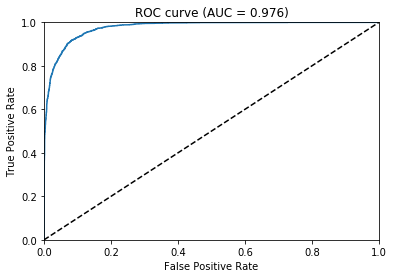

In [15]:
#the ROCAUC score is now 98.0 witht eh 2080 split compared to the 40 60 from before 
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(metrics.roc_auc_score(testY, preds)))

In [16]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(testY, preds)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(thresholds[i], recall[i], precision[i]))

Threshold 0.00022042953060008585, recall = 1.0, precision = 0.43332178732248006
Threshold 0.00022638363589067012, recall = 0.9996003197442046, precision = 0.43427678416391735
Threshold 0.000231526093557477, recall = 0.9996003197442046, precision = 0.4354108635097493
Threshold 0.00023761556076351553, recall = 0.9996003197442046, precision = 0.4365508814801885
Threshold 0.00024179165484383702, recall = 0.9996003197442046, precision = 0.4376968848442422
Threshold 0.000248317199293524, recall = 0.9996003197442046, precision = 0.43884892086330934
Threshold 0.00025473450659774244, recall = 0.9996003197442046, precision = 0.4400070372976777
Threshold 0.00026085608988069, recall = 0.9996003197442046, precision = 0.44117128241312403
Threshold 0.0002683935163076967, recall = 0.9996003197442046, precision = 0.4423417049876194
Threshold 0.0002749137638602406, recall = 0.9996003197442046, precision = 0.4435183543181415
Threshold 0.00027910980861634016, recall = 0.9996003197442046, precision = 0.444

AUC Score (Test): 0.959078


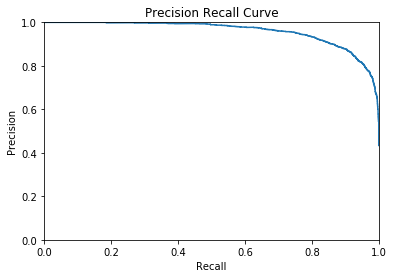

In [17]:
#draw precison recall curve
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall Curve')
print("AUC Score (Test): %f" % metrics.average_precision_score(testY, preds))
plt.show()

[0.9999231  0.9995815  0.81164235 0.99989927 0.999887  ]
2502 4498
[3232.  199.   91.   63.   50.   41.   32.   24.   35.   32.   22.   19.
   14.   13.   18.   22.   20.   12.   13.   15.   11.   15.   20.   12.
   13.   20.    7.    9.   13.    9.   14.   18.   13.    9.   13.   17.
   11.   15.    8.   16.   16.   16.   12.   22.   20.   23.   28.   30.
   32.   69.]
[  17   12    9    5    3    6    8    5    2   10    8    8    0    8
    4    4    5    6    5    9    7   11    5    6    6    6    3    8
    5    4    5    6   12    8    9   12   13   17   14   18   20   22
   20   31   37   33   52   77  160 1276]


(0, 350)

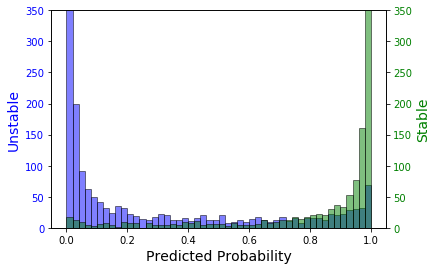

In [18]:
# Histogram:
bins = 50
Stable=preds[np.where(testY==1)]
print(Stable[:5][:])
Unstable=preds[np.where(testY==0)]
print(Stable.size, Unstable.size)


fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,350]) # goes up to ~4300
ax2.set_ylim([0,350]) # goes up to ~2100

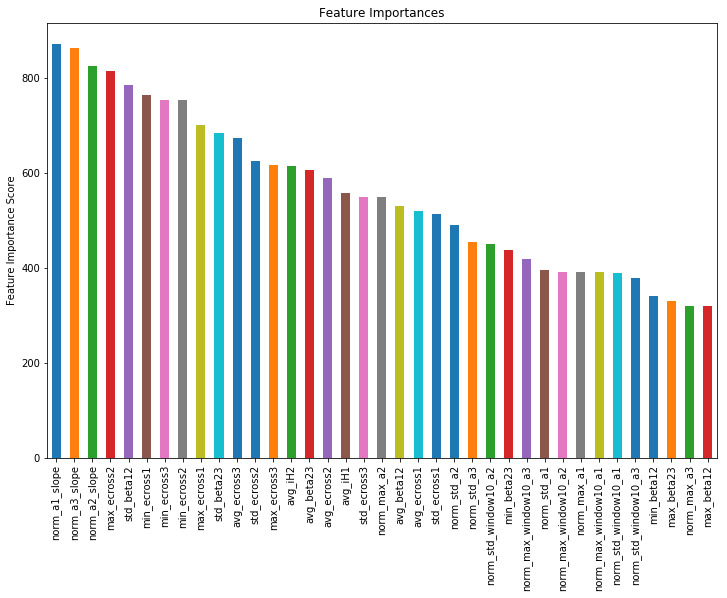

In [19]:
# feature importances
feat_imp = pd.Series(best_xgbc.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [20]:
import dill
import sys
dill.dump([best_xgbc, features], open(datapath+"../models/orbsummaryfeaturesxgb_combined.pkl", "wb"))